# Data Preprocessing and EDA - Paulina Zal

03.05.2023

## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import chardet
import re
from textblob import TextBlob
import string
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import _stop_words as sklearn_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import seaborn as sns
import numpy as np
from nltk.probability import FreqDist
from google.colab import drive

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Read Data

In [ ]:
!wget https://www.dropbox.com/s/13n16xb8qg4ch9r/esg_documents_for_dax_companies.csv

--2023-05-03 19:31:20--  https://www.dropbox.com/s/13n16xb8qg4ch9r/esg_documents_for_dax_companies.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/13n16xb8qg4ch9r/esg_documents_for_dax_companies.csv [following]
--2023-05-03 19:31:20--  https://www.dropbox.com/s/raw/13n16xb8qg4ch9r/esg_documents_for_dax_companies.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc09307f2adad343842fdd13a72d.dl.dropboxusercontent.com/cd/0/inline/B7VyuHiGkCVcrlW3BFoNUzm0_l_e2dMzroHvyQslkBbf_vuERO9B7WogkhuHFKVrjFlNjBY4ff5bVa1fc3OYvi_HHE9-rAd6RGmlasfi6XqAZM3jj3oUeBRf14JXsVhZkPSKoA1QhspsrN1BJw6sakC-qsEZ5bJj-KUHaJ4GapIsYQ/file# [following]
--2023-05-03 19:31:21--  https://uc09307f2adad343842fdd13a72d.dl.dropboxusercontent.com/cd/0/inline/B7VyuHiGkCV

In [ ]:


df = pd.read_csv('./esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)

In [ ]:
df.head()

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url
2,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN
3,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN
5,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN
6,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN
9,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11188 entries, 2 to 11095
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company     11188 non-null  object
 1   content     11187 non-null  object
 2   datatype    11006 non-null  object
 3   date        11188 non-null  object
 4   domain      11096 non-null  object
 5   esg_topics  11188 non-null  object
 6   internal    11188 non-null  int64 
 7   symbol      11187 non-null  object
 8   title       11188 non-null  object
 9   url         11096 non-null  object
dtypes: int64(1), object(9)
memory usage: 961.5+ KB


In [ ]:
df.shape

(11188, 10)

# Data Cleaning

In [ ]:
df['date'] = pd.to_datetime(df['date'],errors='coerce')##  e.g "p.DE-03-31" to NaN


In [ ]:

df["esg_topics"]=df["esg_topics"].str.findall(r'(\w+)')
df["esg_topics"]=[','.join(map(str, l)) for l in df["esg_topics"]]
df["esg_topics"]=df["esg_topics"].str.lower()
dummies=df["esg_topics"].str.get_dummies(',')
df=pd.concat([df,dummies],axis=1)
dummies_columns=dummies.columns


In [ ]:
df.content=df.content.str.replace("¡¯","ʼ",regex=True)  \
        .str.replace("¨C","-",regex=True) \
        .str.replace("\'","ʼ",regex=True) \
        .str.replace("¡°", '"',regex=True) \
        .str.replace("¡±", '"',regex=True) \
        .str.replace("¡ã","°",regex=True) \
        .str.replace("¨¹", "ü",regex=True) \
        .str.replace("¡ª","",regex=True) \
        .str.replace("¨c","",regex=True) \
        .str.replace("¨¦","e",regex=True) \
        .str.replace("•","",regex=True) \
        .str.replace("–","",regex=True) 

df.content=df.content.replace(' @ ', '@',regex=True)

# replace email addresses with an empty string
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
df.content = df.content.str.replace(email_regex, '',regex=True)
#lowecase
df.content = df.content.str.lower()
# replace url addresses with an empty string
url_pattern = r'(http[s]?:\/\/(?:www\.)?\S+)|(www\.\S+)'
df.content = df.content.str.replace(url_pattern, '',regex=True)

#delete brackets and its content
contains_brackets=r'\([^)]*\)'
df.content=df.content.str.replace(contains_brackets, '',regex=True)

#replace phone numbers 
pattern_tel1 = r'\+49\s*\d{1,4}\s*\d{1,4}[\s-]*\d{1,4}'
pattern_tel2 = r'\+49\s*\(\d\)\s*\d{4}-\d{2}\s*\d'
pattern_tel3= r'\+\d{2}\.\d{3}\.\d{3}\.\d{1,4}'
# replace website addresses with an empty string
df.content = df.content.str.replace(pattern_tel1, '',regex=True)
df.content = df.content.str.replace(pattern_tel2, '',regex=True)
df.content = df.content.str.replace(pattern_tel3, '',regex=True)

#delete pages (e.g. "page(s) 44-55")
pattern_pages=r'(?:p\s)?(\d{1,4})[-–](\d{1,4})'
df.content = df.content.str.replace(pattern_pages, '',regex=True)
#delete pages 
pattern_page=r'\b(p(ages)?\.?\s*\d+|\bpage(s)?\s+\d+)\b'
df.content = df.content.str.replace(pattern_page, '',regex=True)

# Remove punctuation from 'content' column
regex = '[' + string.punctuation + ']'
df.content = df.content.str.replace(regex, '',regex=True)

# delete numbers
num_pattern=r'\d+(\.\d+)?'
df.content = df.content.str.replace(num_pattern, '',regex=True)

pattern_symbols = r'[$€™©]'
df.content =df.content.str.replace(pattern_symbols,'',regex=True)


#delete multiple spaces
df.content=df.content.replace(r'\s+', ' ', regex=True)


In [ ]:
def lemmatize_text(tokens):
    
    lemmatized_words = [word.lemma_ for word in nlp(" ".join(tokens)) if word.lemma_  not in stop_words_nltk]

    return ' '.join(lemmatized_words)

In [ ]:
#tokenization
stop_words_nltk = stopwords.words('english')
df.content=df.content.astype(str)
df.content = df.content.apply( lambda x: word_tokenize(x))
df.content = df.content.apply( lambda x: [word for word in x if word not in stop_words_nltk])


In [ ]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000
lemmatizer = WordNetLemmatizer()
#lematization
df.content = df.content.apply(lambda x:lemmatize_text(x))
df.content=df.content.str.replace(regex,"",regex=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploratory Data Analyzis

## Number of Documents per company

<Axes: xlabel='company'>

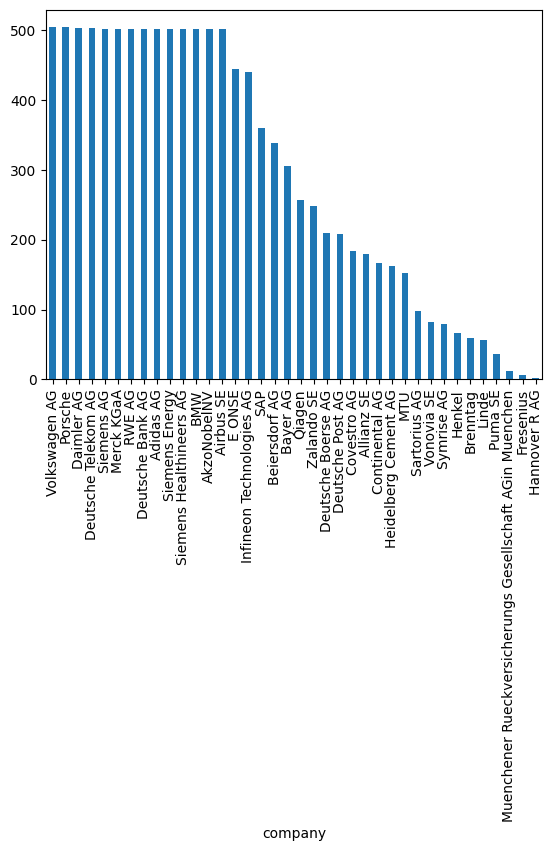

In [ ]:
df.groupby("company")["content"].count().sort_values(ascending=False).plot(kind="bar")

14 companies have about 500 documents. 8 have less than 100.

## Number of documents per company (separated into internal and external)

<Axes: xlabel='company'>

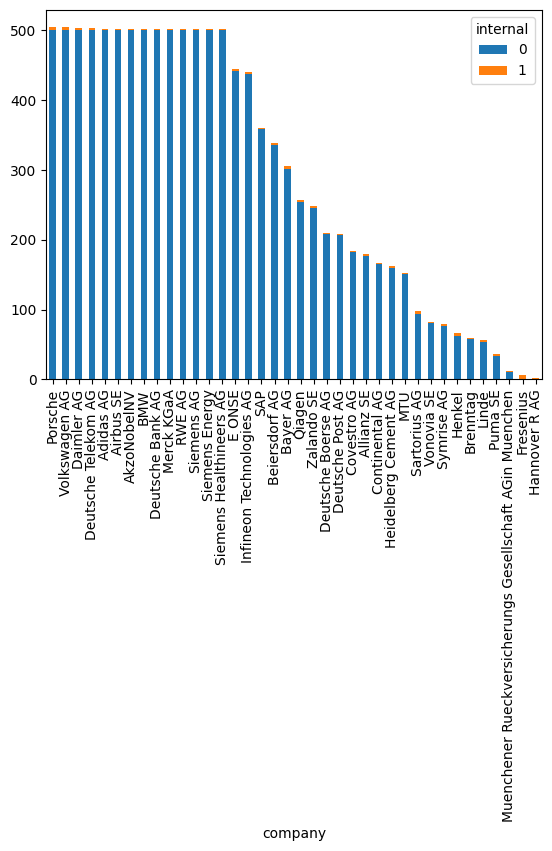

In [ ]:
df.groupby(["company","internal"])["content"].count().unstack().sort_values(by=[0,1],ascending=False).plot(kind='bar', stacked=True)

The most of the companies have own documents, there is only a few reports per company that is from third-parties

## Number of document per datatype

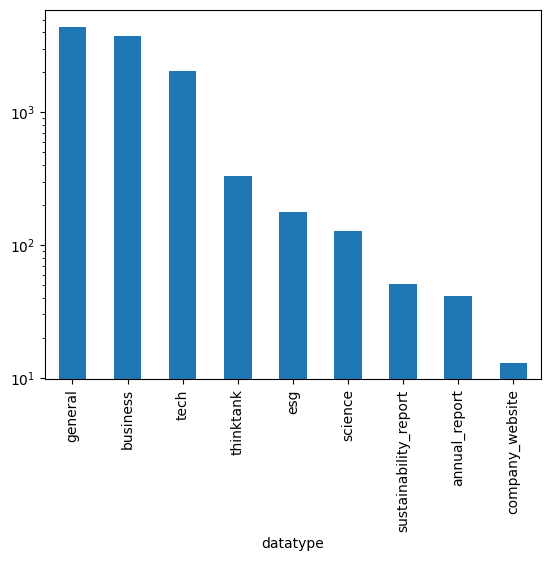

In [ ]:
df.groupby(["datatype"])["content"].count().sort_values(ascending=False).plot(kind='bar', stacked=True)
plt.yscale('log')

Top 3 reports are general,business, tech. In the next step I will focus on this three reports and companies

## Three main datatypes - analasis for company

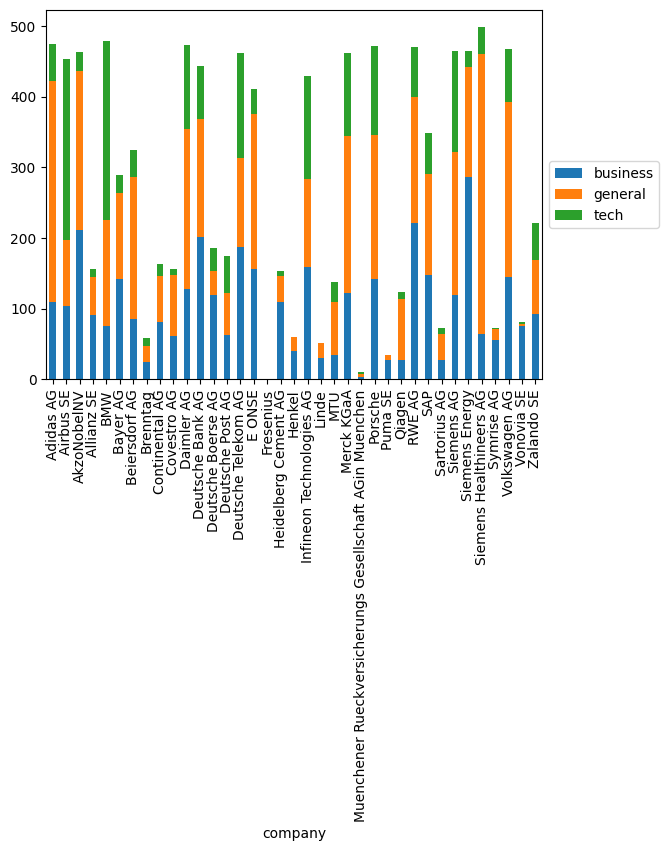

In [ ]:
reports_top_3 =df[df["datatype"].isin(["general","business","tech"])]
reports_top_3.groupby(["datatype","company"])["content"].count().unstack().T.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

The data type for most companies are general and bussiness. The majority of documents for Airbus and BMW is tech.



## Time-series of ESG topic distributions 

<ipython-input-52-5a81a0b5fb11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends.date=trends.date.dt.to_period("M")
<ipython-input-52-5a81a0b5fb11>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  trends_agg.sum_all=trends_agg.sum(axis=1)


(612.0, 639.0)

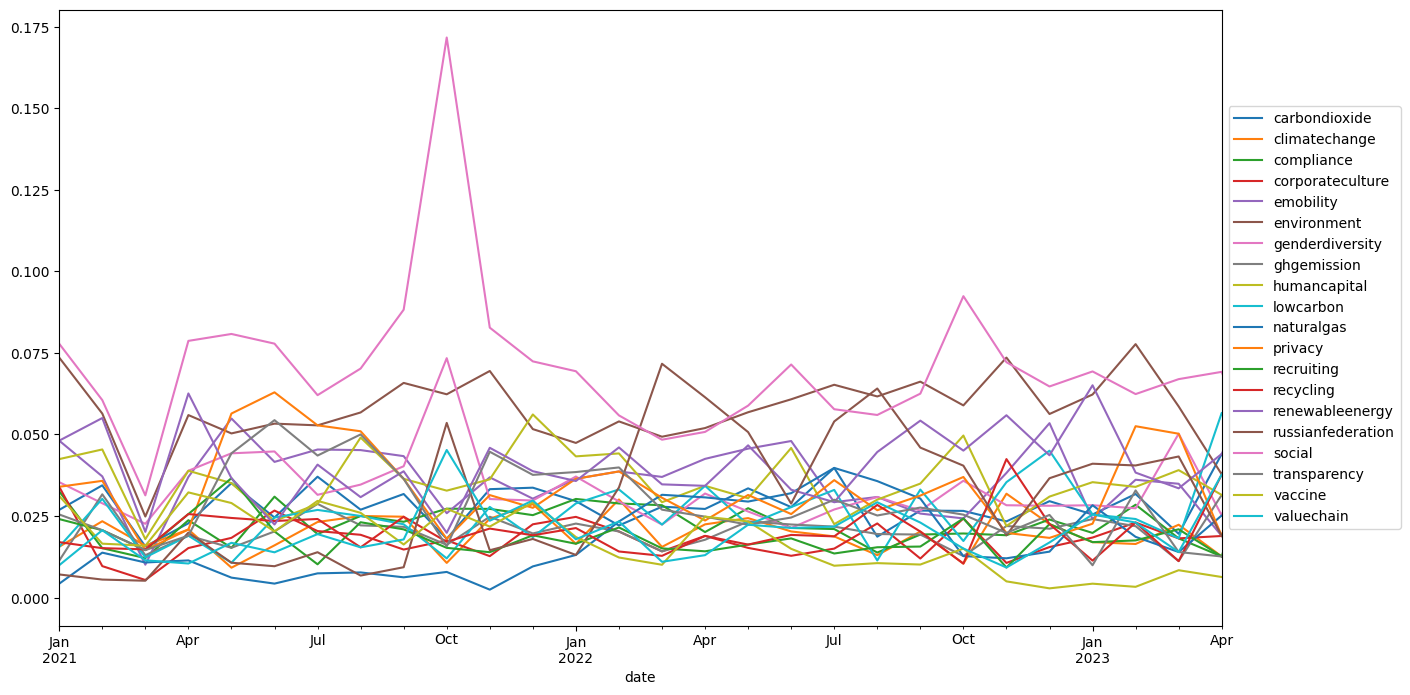

In [ ]:
columns=["date"]+list(dummies_columns)
topics_trends=df[columns]
trends=topics_trends[topics_trends["date"].notna()]
trends.date=trends.date.dt.to_period("M")
trends_agg=trends.groupby("date").sum()
column_trends=trends_agg.columns
trends_agg.sum_all=trends_agg.sum(axis=1)
trends_agg = trends_agg.div(trends_agg.sum_all, axis=0) #create distribution of topics pro time range
trends_agg.reset_index(inplace=True)
trends_unpivot=pd.melt(trends, id_vars='date', value_vars=trends.columns)
top_topics=list(trends_unpivot.groupby("variable")["value"].sum().sort_values(ascending=False)[0:20].index) #top 20 topics
trends_agg.set_index("date", inplace=True)
trends_agg=trends_agg.loc[:, trends_agg.columns.isin(top_topics)] #show only top topics due to readiness
trends_agg.plot.line(figsize=(15,8))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlim('2021-01-01','2023-04-01')
#topics_trends=df[["date",[dummies_columns]]]

The figure above shows only 20 most popular topics out of xx. This is because more characteristics were unreadabale. We can see peaks in Oct 2021 for genderdiversity,socialenvironment. This may be correlated with elections in Germany. We can also observe an increasing trend for russianfederation and natural gas starting in Jan 2022 (may be correlated with the war in the Ukraine)

## Wordcloud of topics

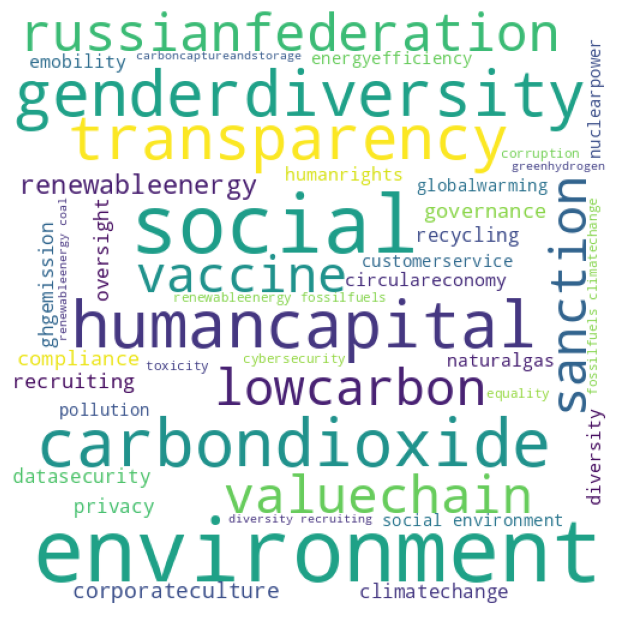

In [ ]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(df.esg_topics.str.cat())
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

The mostly used topics are among other: environment, social, human capital, gender diversity, transparency

## Average number of words among datatypes

In [ ]:
df["content_len"]=df.content.apply(lambda x: word_tokenize(x))
df["no_words"]=df.content_len.str.len()

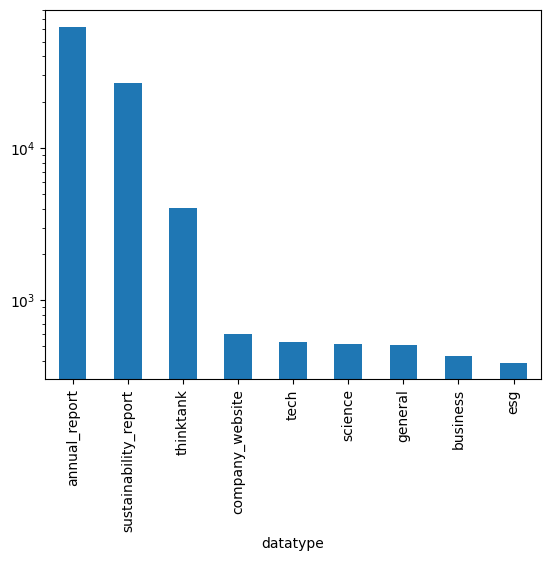

In [ ]:

df.groupby(["datatype"])["no_words"].mean().sort_values(ascending=False).plot.bar()
plt.yscale('log')

On average, the annual reports are the longest one in terms of used words, followd by sustainability reports. The shortest are esg.

## Average number of words among internal and external documents


<Axes: xlabel='internal'>

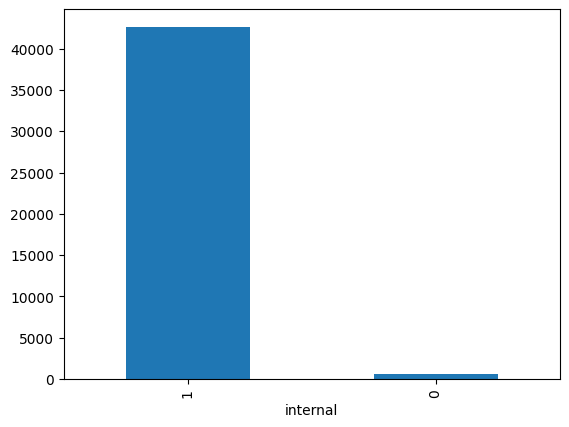

In [ ]:

df.groupby(["internal"])["no_words"].mean().sort_values(ascending=False).plot.bar()

Also the external documents are on average longer, than internal.

## Most characteristic words per company


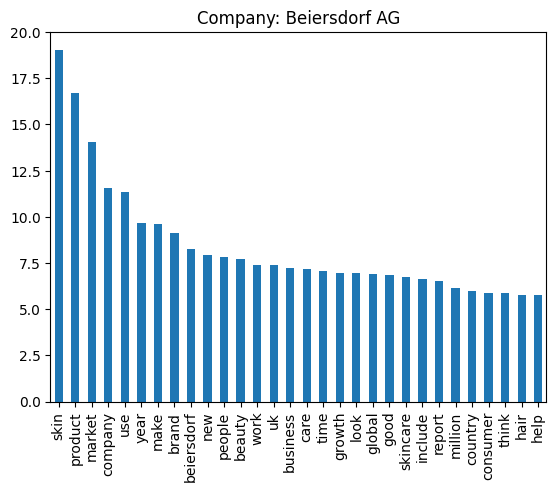

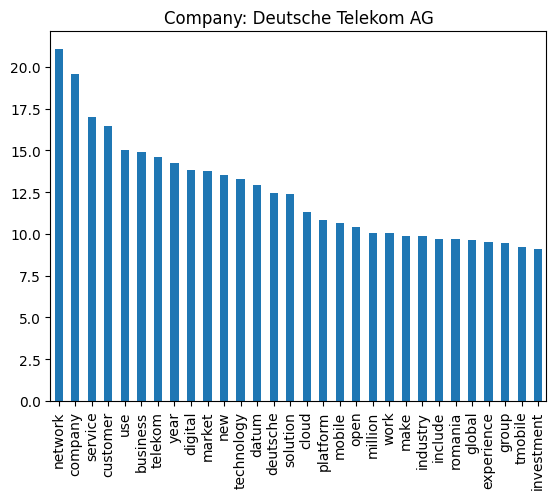

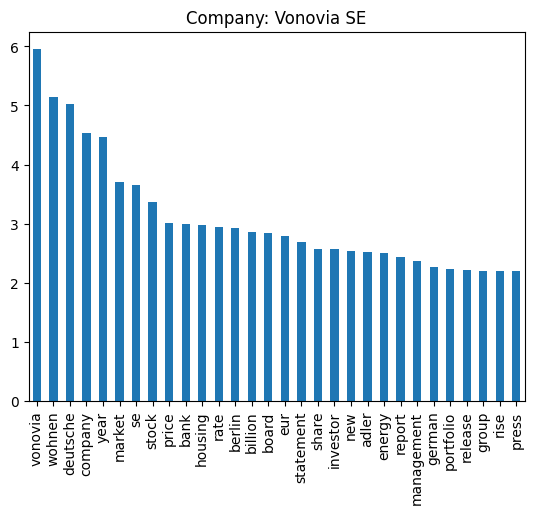

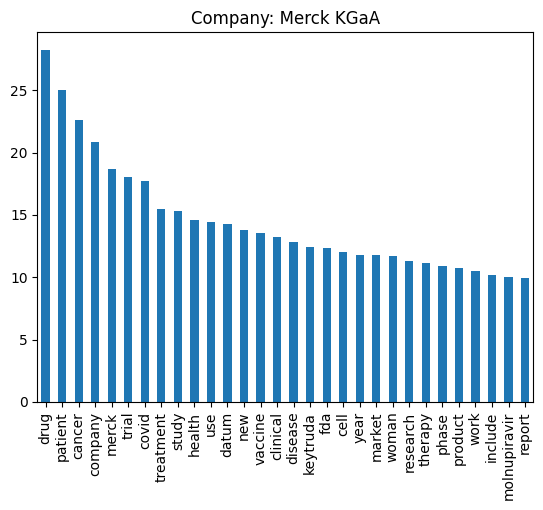

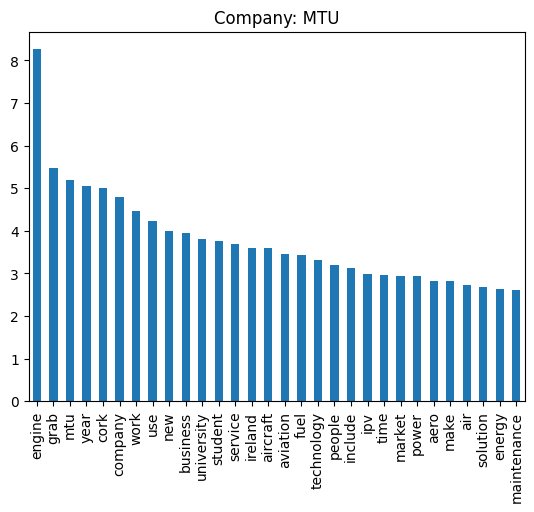

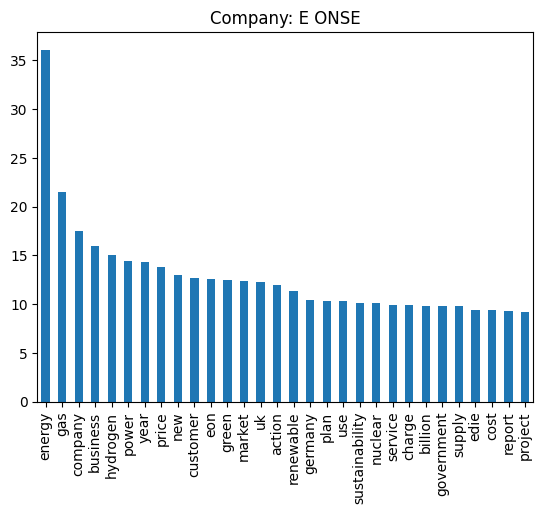

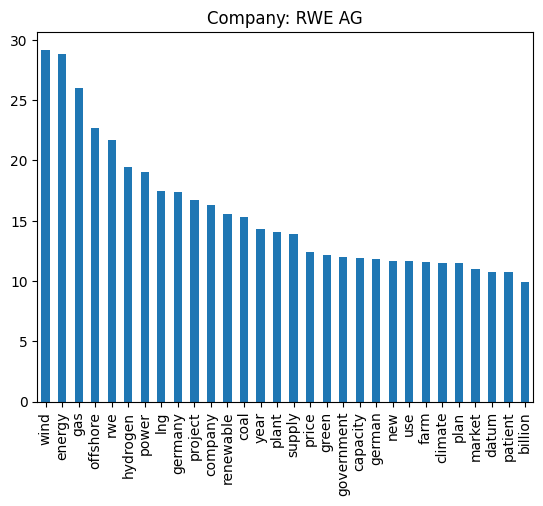

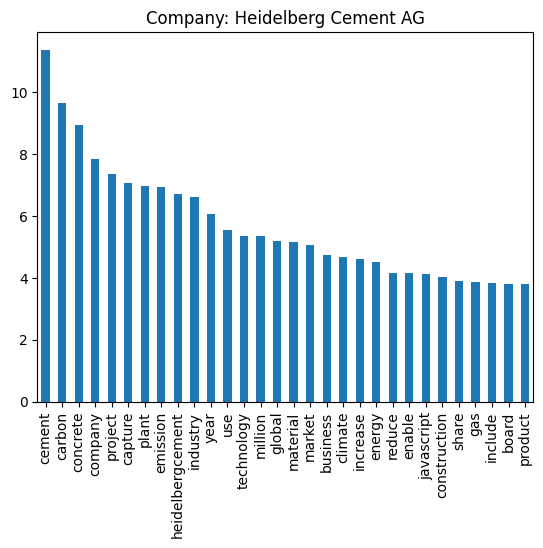

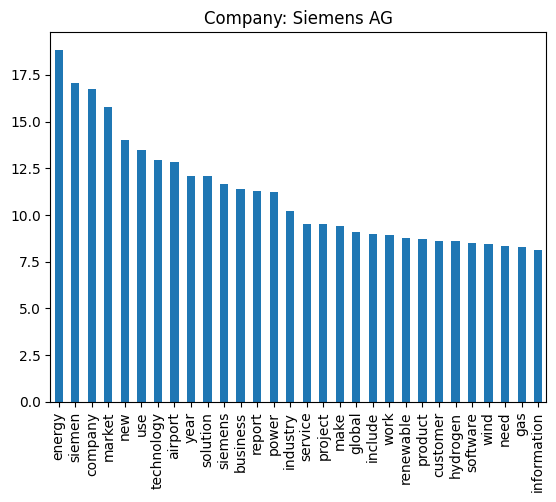

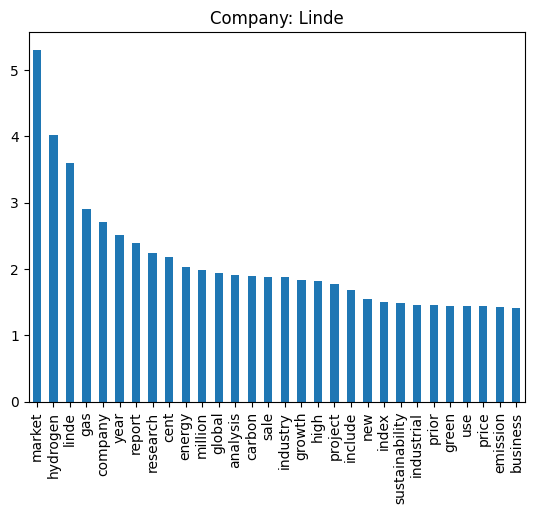

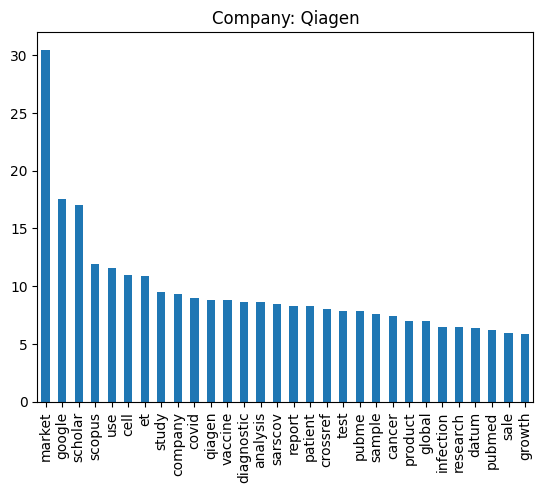

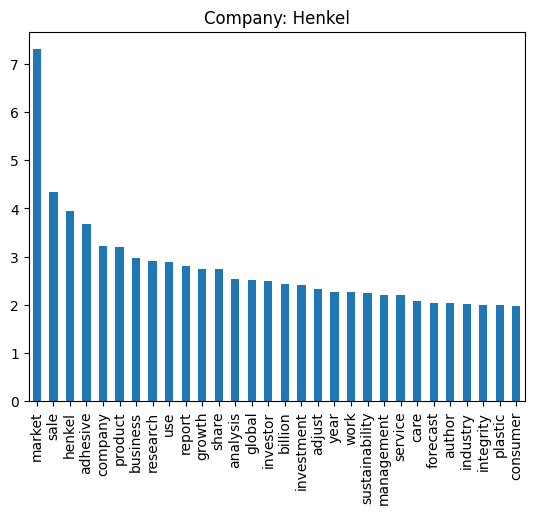

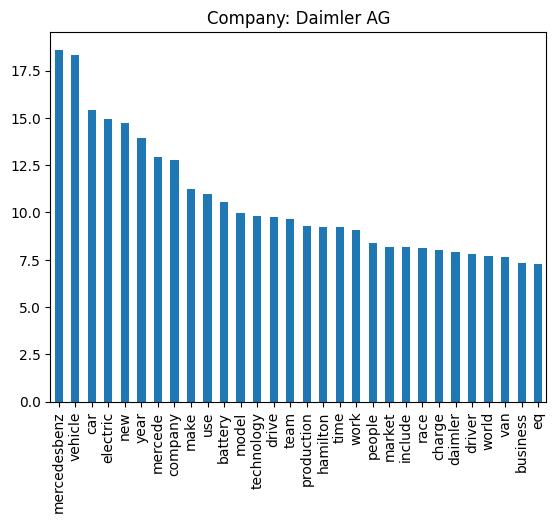

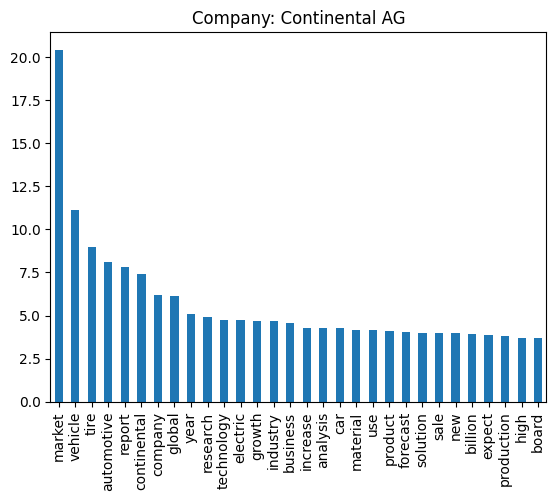

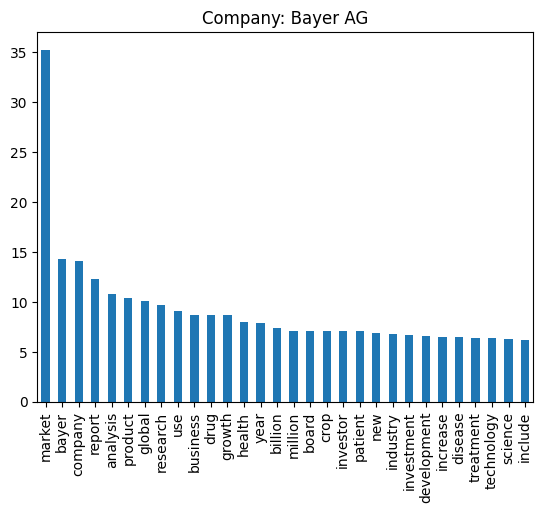

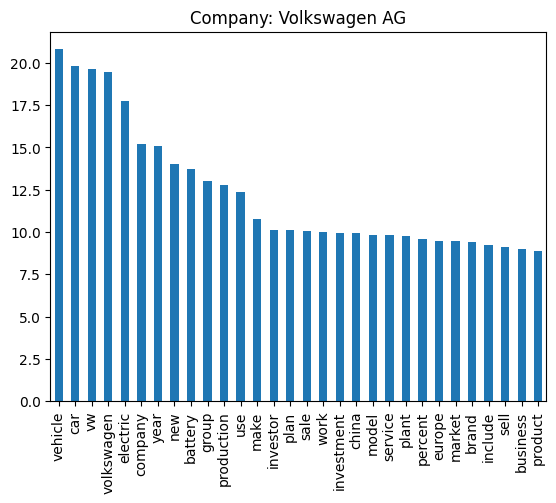

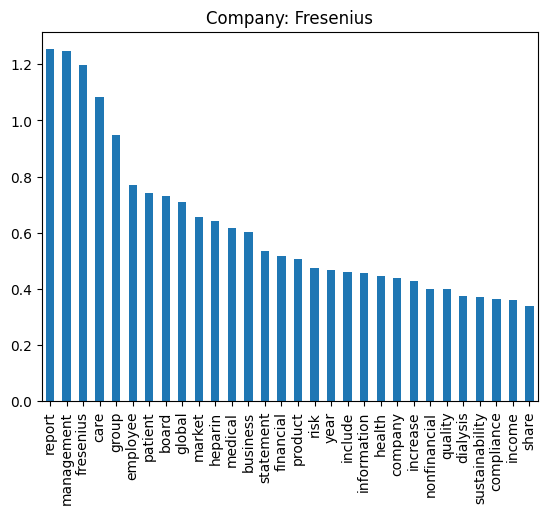

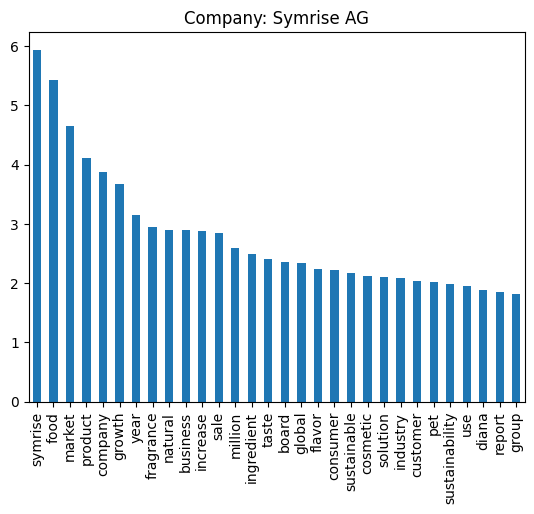

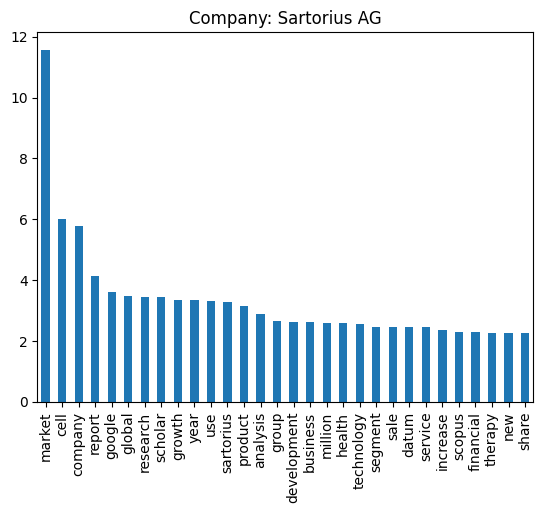

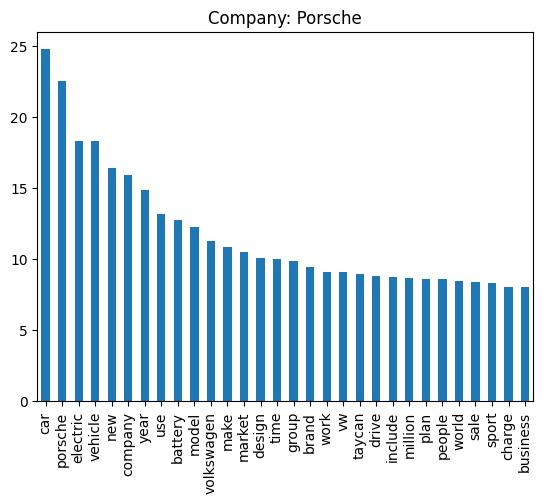

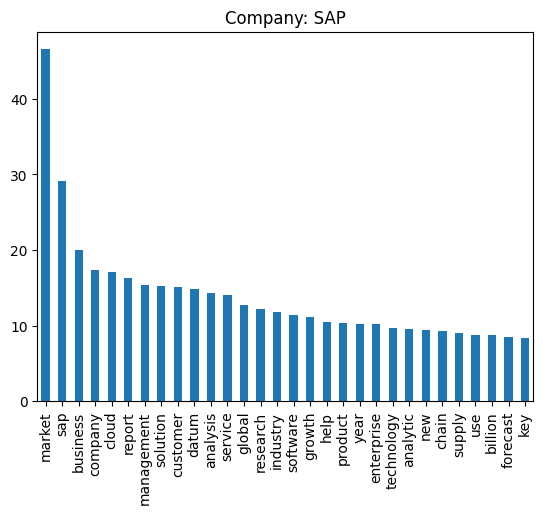

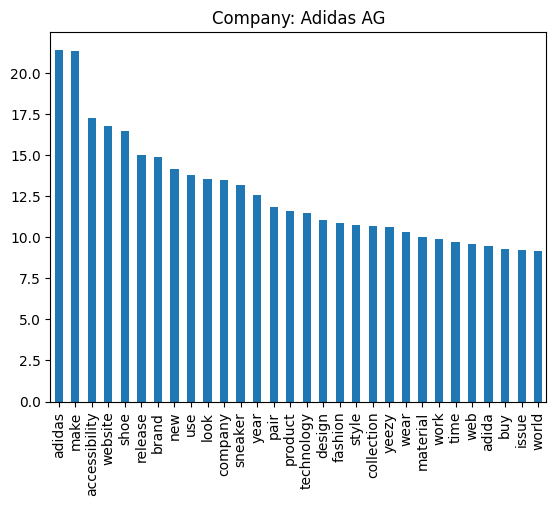

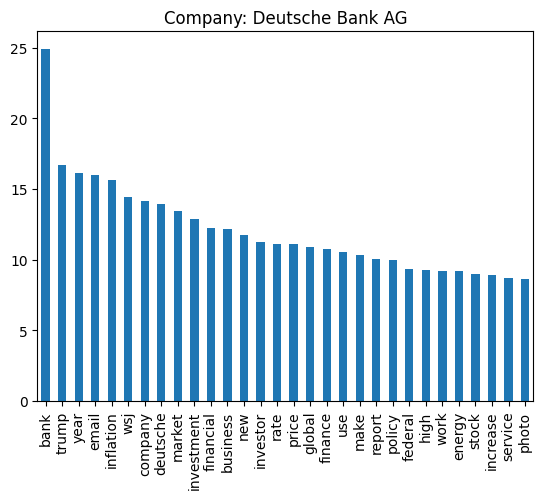

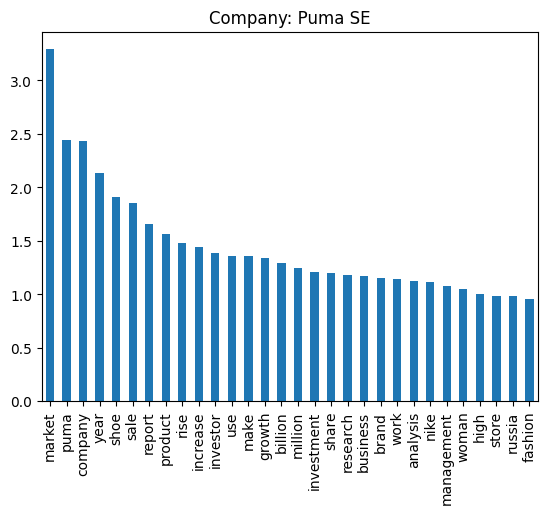

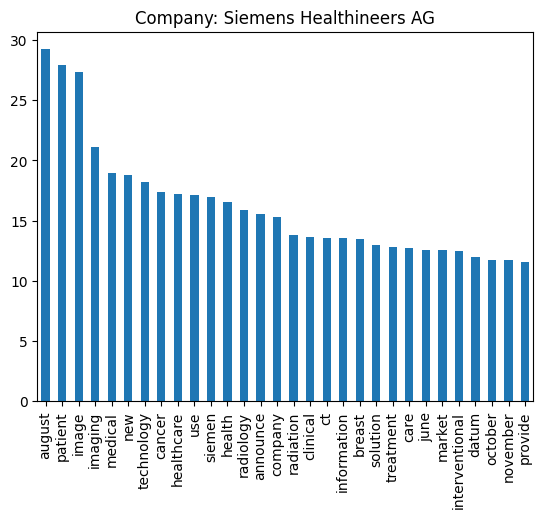

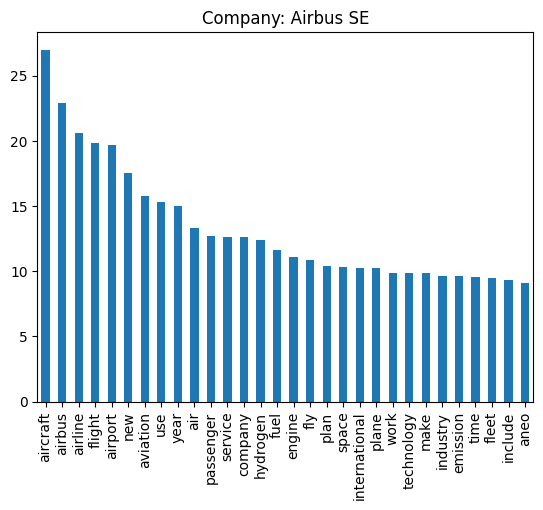

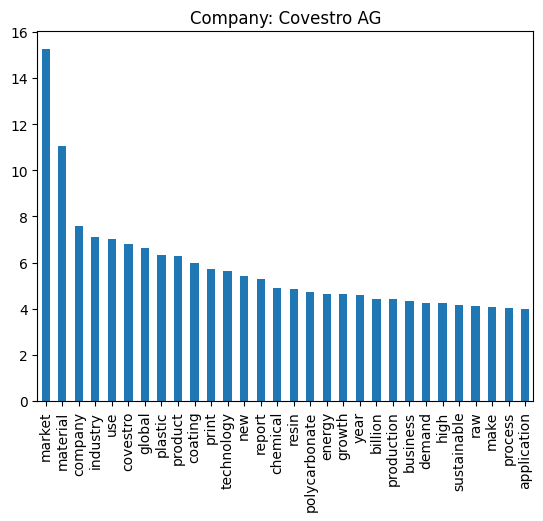

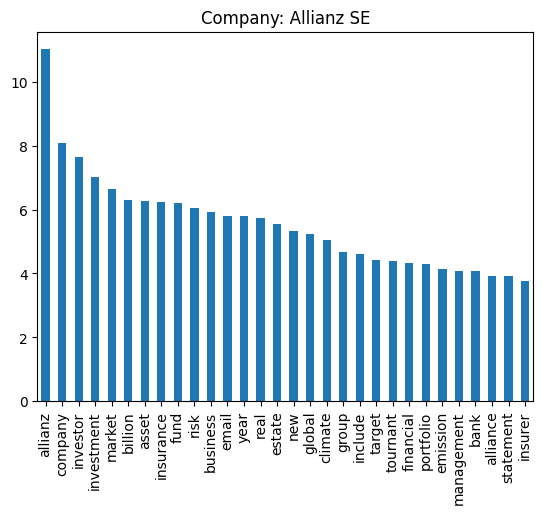

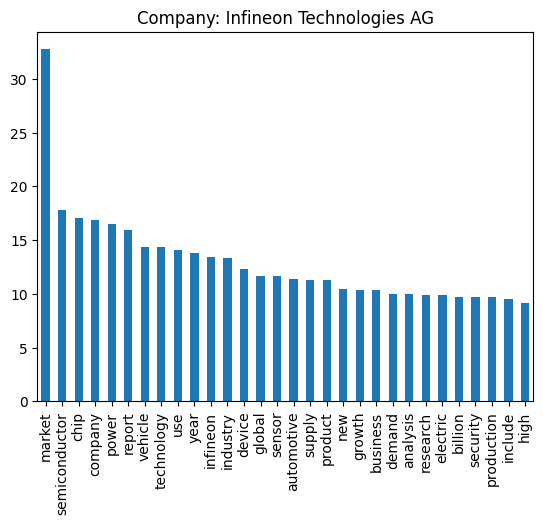

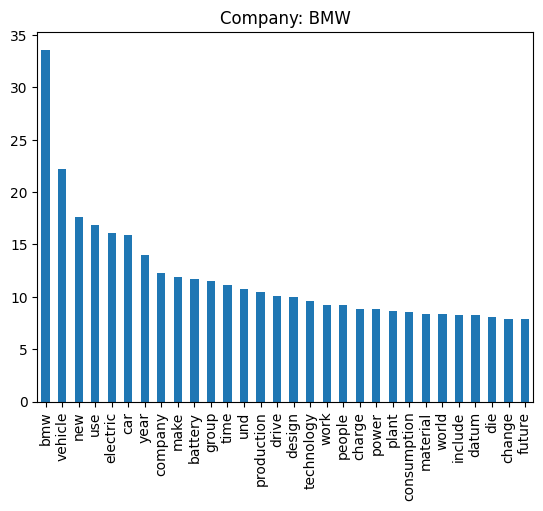

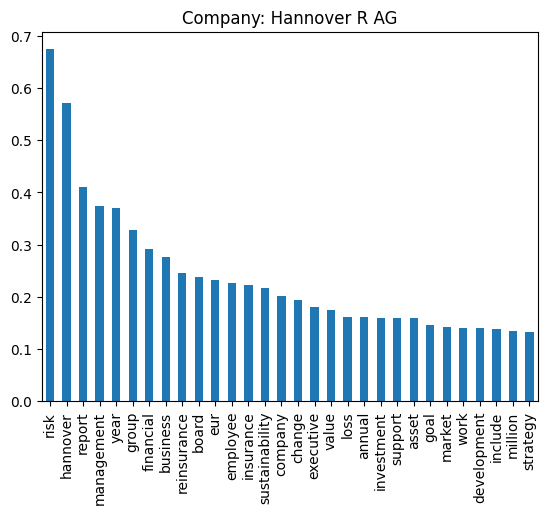

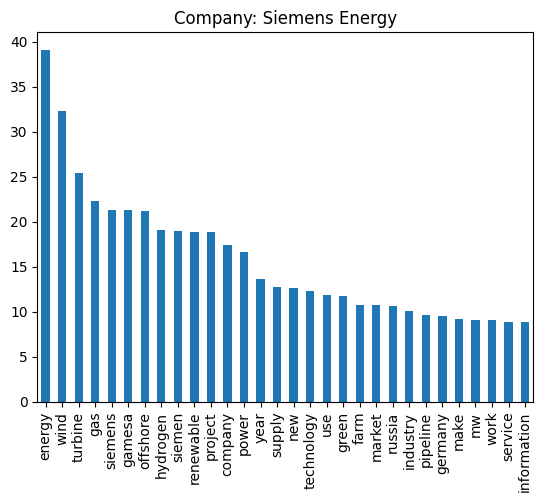

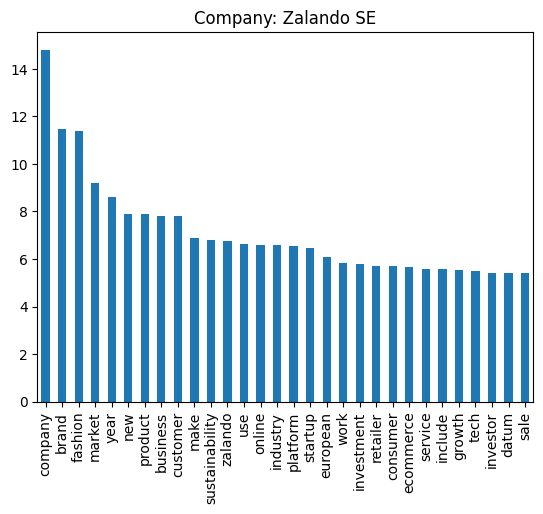

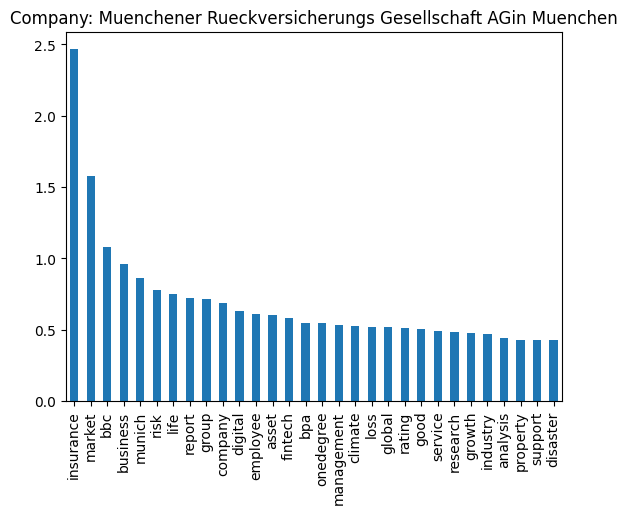

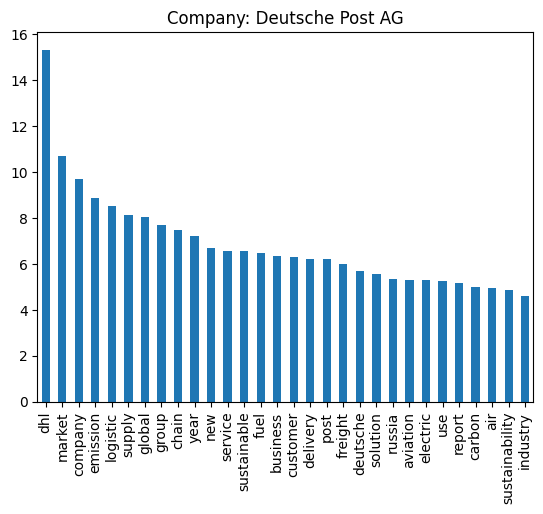

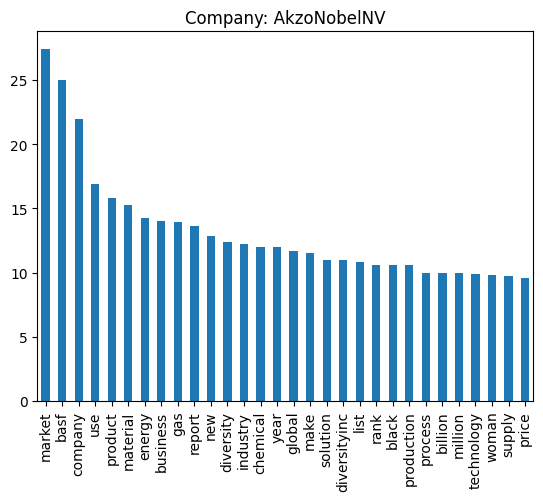

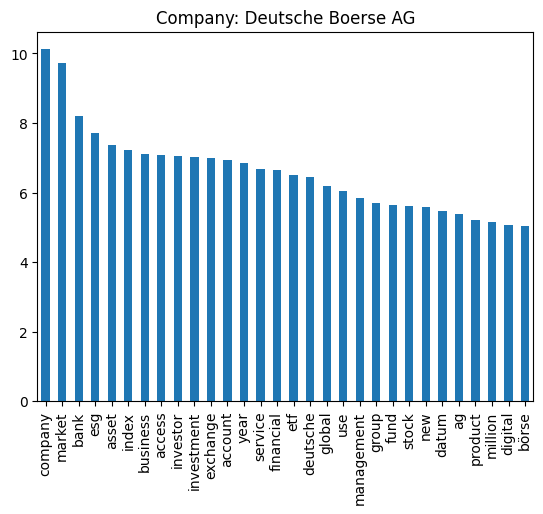

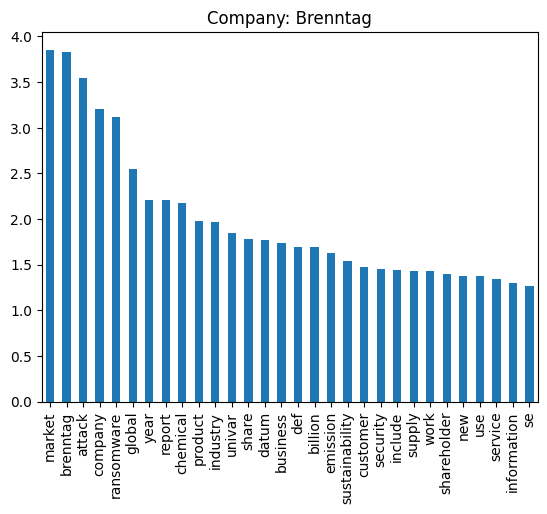

In [ ]:
# Grab standard English stopwords
stop_words = set(sklearn_stop_words.ENGLISH_STOP_WORDS)
# And add in some of our own ("like" is really common and doesn't tell us much)
stop_words = list(stop_words.union(set([
    "www", "http", "https", "br", "amazon", "href", "wa", "ha",
    "like", "just", "say", "it's","ʼʼ","itʼs","table","content","figure"
])))
company_name=df.company.unique()
for name in company_name:
    company=df[df["company"]==name]
    tfidf_vectorizer = TfidfVectorizer(
        #max_df=  1, # Remove any words that appear in more than 90% of our documents
        #min_df=5, # Remove words that appear in fewer than 5 document
        ngram_range=(1, 1), # Only extract unigrams
        stop_words=stop_words, # Remove stopwords
        max_features=2500 # Grab the 2500 most common words (based on above constraints)
    )
    df_tfidf=df[df["content"].notna()]
    tfidf = tfidf_vectorizer.fit_transform(company['content'])
    ngrams = tfidf_vectorizer.get_feature_names_out()
    ngram_df = pd.DataFrame(tfidf.todense(), columns=ngrams)
    ngram_df.sum().sort_values(ascending=False)[:30].plot(kind="bar")
    plt.title("Company: "+name)
    plt.show()


The plots show the most characteristc words per company. As example: for Deutsche Postit is DHL, market ,company, emissions and logistics.  For Airbus:aircraft, airbus, airline. 
The words can mostly assosciated with the bussines and development.

## Number of words among companies


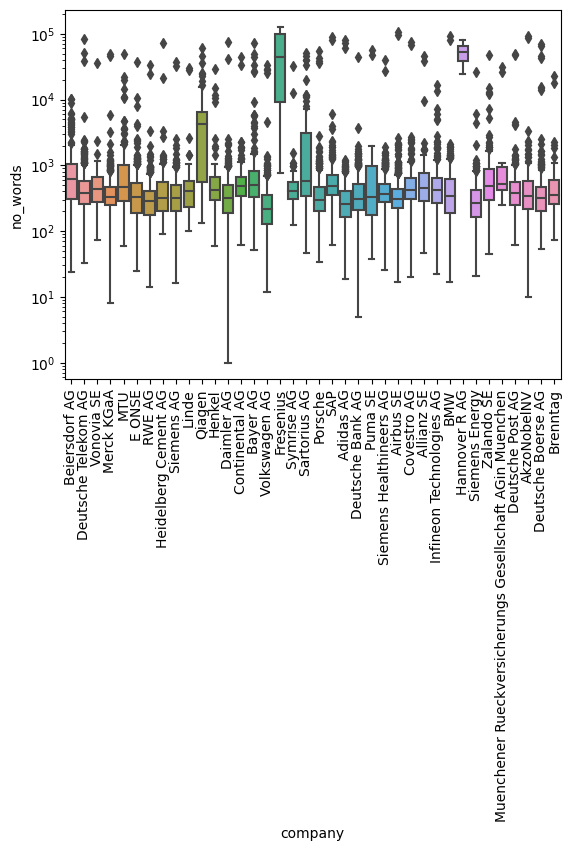

In [ ]:
sns.boxplot(x="company", y="no_words", data=df)
plt.xticks(rotation = 90) 
plt.yscale('log')
plt.show()

The characteristics of number of words distribution is similar among companies. The longest are by Fresenius and Hannover R AG. These are also the companies with the smallest numbers of documents.

## Polarity across companies

In [ ]:
df['Polarity'] = df['content'].map(lambda text: TextBlob(str(text)).sentiment.polarity) 

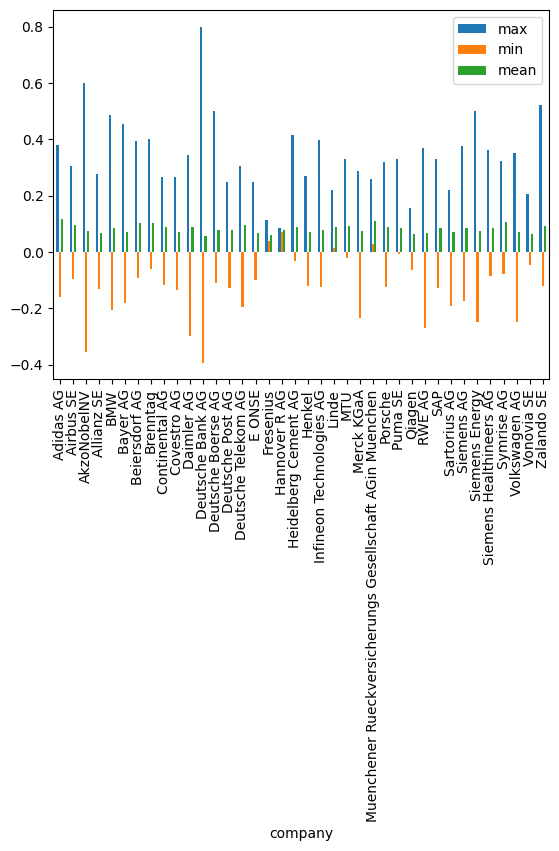

In [ ]:
#sns.boxplot(x="datatype", y="Polarity", data=df)
df.groupby("company")["Polarity"].agg([max,min,np.mean]).plot(kind="bar") 
plt.xticks(rotation = 90) 

plt.show()

The biggest difference between maximal and minimal polarity are for finnce institutions such as Allianz SE and Deutsche Bank. Average polarity is smilar among companies.

## Most common words for companies

In [ ]:
companies=df.company.unique()
for company in companies:
    df_bmw=df[df["company"]==company]
    df_bmw=df_bmw.groupby("company")["content_len"].agg(sum)
    df_bmw=pd.DataFrame(df_bmw)
    from nltk.probability import FreqDist
    #fdist = FreqDist(df_bmw["content_len"])
    fdist=FreqDist(df_bmw["content_len"][0])
    top_ten = fdist.most_common(5)
    print(company)
    print(top_ten)

Beiersdorf AG
[('product', 1855), ('skin', 1594), ('ʼʼ', 1540), ('use', 1493), ('say', 1402)]
Deutsche Telekom AG
[('company', 2637), ('group', 2464), ('also', 2217), ('service', 2093), ('year', 1979)]
Vonovia SE
[('vonovia', 897), ('report', 554), ('year', 537), ('company', 526), ('also', 500)]
Merck KGaA
[('company', 1857), ('patient', 1731), ('merck', 1721), ('drug', 1694), ('health', 1535)]
MTU
[('release', 2504), ('press', 2473), ('mtu', 1947), ('global', 1617), ('company', 1235)]
E ONSE
[('energy', 3028), ('say', 1785), ('eon', 1527), ('company', 1517), ('gas', 1323)]
RWE AG
[('rwe', 2668), ('energy', 2247), ('say', 1646), ('wind', 1416), ('power', 1320)]
Heidelberg Cement AG
[('cement', 1392), ('heidelbergcement', 1253), ('company', 1154), ('year', 1103), ('million', 1097)]
Siemens AG
[('siemen', 2241), ('year', 1444), ('company', 1437), ('system', 1362), ('business', 1275)]
Linde
[('linde', 1594), ('report', 741), ('company', 665), ('million', 590), ('include', 523)]
Qiagen
[('